In [12]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [13]:
df = pd.read_csv('nyc_subway_ml_data.csv')

# one hote enoding - station, borough
df = pd.get_dummies(df, columns = ['station'], prefix = 'sta')
df = pd.get_dummies(df, columns = ['borough'], prefix = 'boro')
df= df.drop('transaction_time', axis = 1)

oh_cols = [c for c in df.columns if c.startswith('boro_') or c.startswith('sta_')]
df[oh_cols] = df[oh_cols].astype('float32')

# reformat chronological data 
# with just integers, the model will consider weekday 1 and weekday 6 unrelated
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

col_X = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
         'weekday_sin', 'weekday_cos', 'isweekend', 'is_rush_hr', 'is_holiday', 
         'hr_lag', 'day_lag', 'week_lag', 'is_raining', 'precip', 'temp']

scale_X = StandardScaler()
X_ss = scale_X.fit_transform(df[col_X])
X_oh = df[oh_cols].values
X_all = np.hstack([X_ss, X_oh])

# Scaling y values
y_none = df['entry_per_hour'].values
scale_y = MinMaxScaler()
y_scaled = scale_y.fit_transform(df[['entry_per_hour']])

# split data
train_all = df['month'] <= 10
test_all = df['month'] > 10

# split train / test
X_train = X_all[train_all]
X_test = X_all[test_all]

y_train_rf = y_none[train_all]
y_test_rf = y_none[test_all]

y_train_nn = y_scaled[train_all]
y_test_nn = y_scaled[test_all]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train_rf shape: {y_train_rf.shape}")
print(f"y_test_rf shape:  {y_test_rf.shape}")

X_train shape: (356400, 69)
X_test shape:  (73200, 69)
y_train_rf shape: (356400,)
y_test_rf shape:  (73200,)


In [14]:
# random forest regressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 67)
rf.fit(X_train, y_train_rf)
pred = rf.predict(X_test)

mse = mean_squared_error(y_test_rf, pred)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test_rf, pred)
r2 = r2_score(y_test_rf, pred)

print(f'R2 Score (Accuracy): {r2:.4f}') 
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'MSE: {mse:.4f}')

R2 Score (Accuracy): 0.9648
RMSE: 294.8261
MAE:  123.9746
MSE: 86922.4181


In [15]:
# basic neural network
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Input Layer
model_nn = Sequential()

model_nn.add(Dense(256, input_dim = X_train.shape[1], activation = 'relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))

model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dropout(0.2))

model_nn.add(Dense(64, activation = 'relu'))
model_nn.add(Dense(1, activation = 'linear'))

model_nn.compile(loss='mean_absolute_error', optimizer='adam')
history_nn = model_nn.fit(X_train, y_train_nn, epochs = 100, batch_size = 64, 
                    validation_data = (X_test, y_test_nn), callbacks = [early_stopping, lr_scheduler], verbose = 1)

Epoch 1/100


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 6s 826us/step - loss: 0.0252 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 2/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 801us/step - loss: 0.0101 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 3/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 793us/step - loss: 0.0085 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 4/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 796us/step - loss: 0.0079 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 5/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 791us/step - loss: 0.0076 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 6/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step - loss: 0.0073 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 792us/step - loss: 0.0072 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 8/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 799us/step - loss: 0.0070 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 9/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 798us/step - loss: 0.0069 - val_loss: 0.0104 -

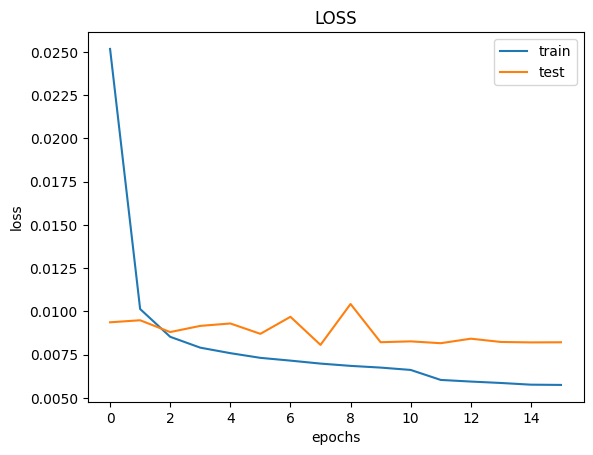

In [16]:
plt.plot(history_nn.history['loss'], label = 'train')
plt.plot(history_nn.history['val_loss'], label = 'test')
plt.legend()
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [17]:
# GRU model - time step = 1 since the data already consider previous data through lag columns 
X_train_gru = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_gru = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model_gru = Sequential()

model_gru.add(GRU(128, return_sequences=False, input_shape=(1, X_train.shape[1])))
model_gru.add(Dropout(0.1))

model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.05)) 

model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='linear'))

model_gru.compile(loss='mean_absolute_error', optimizer='adam')

history_gru = model_gru.fit(
    X_train_gru, y_train_nn, 
    epochs=100, 
    batch_size=256, 
    validation_data=(X_test_gru, y_test_nn), 
    callbacks=[early_stopping, lr_scheduler], 
    verbose=1
)

Epoch 1/100


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 2/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0060 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0055 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0053 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 5/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0051 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0050 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 7/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0049 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 8/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0048 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 9/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0047 - val_loss: 0.0061 - learning_rate: 0.

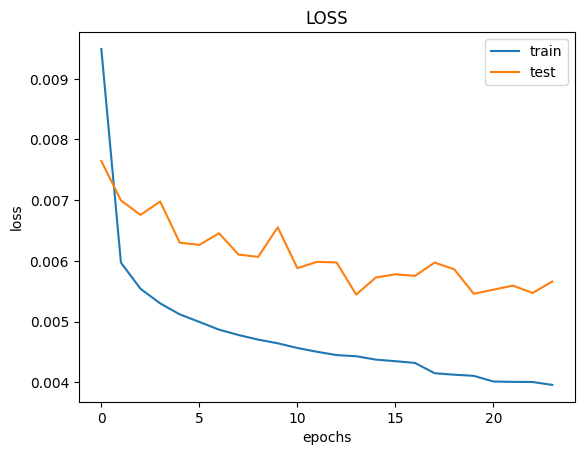

In [18]:
plt.plot(history_gru.history['loss'], label = 'train')
plt.plot(history_gru.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LOSS')
plt.show()

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_rf = rf.predict(X_test)

pred_nn_scaled = model_nn.predict(X_test, verbose=0)
y_pred_nn = scale_y.inverse_transform(pred_nn_scaled)

pred_gru_scaled = model_gru.predict(X_test_gru, verbose=0)
y_pred_gru = scale_y.inverse_transform(pred_gru_scaled)

y_true = y_test_rf.flatten()
y_pred_rf = y_pred_rf.flatten()
y_pred_nn = y_pred_nn.flatten()
y_pred_gru = y_pred_gru.flatten()

predictions_dict = {
    "Random Forest": y_pred_rf,
    "Dense NN": y_pred_nn,
    "GRU": y_pred_gru
}

results_list = []

for name, preds in predictions_dict.items():
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    results_list.append({
        "Model": name,
        "MAE (Real Riders)": round(mae, 2),
        "R2 Score": round(r2, 4)
    })

comparison_df = pd.DataFrame(results_list)
comparison_df = comparison_df.sort_values(by="MAE (Real Riders)", ascending=True)

print("champion")
print(comparison_df.to_string(index=False))

winner = comparison_df.iloc[0]["Model"]
print(f"\nWinner is {winner}")

champion
        Model  MAE (Real Riders)  R2 Score
          GRU             109.80    0.9765
Random Forest             123.97    0.9648
     Dense NN             162.78    0.9548

Winner is GRU


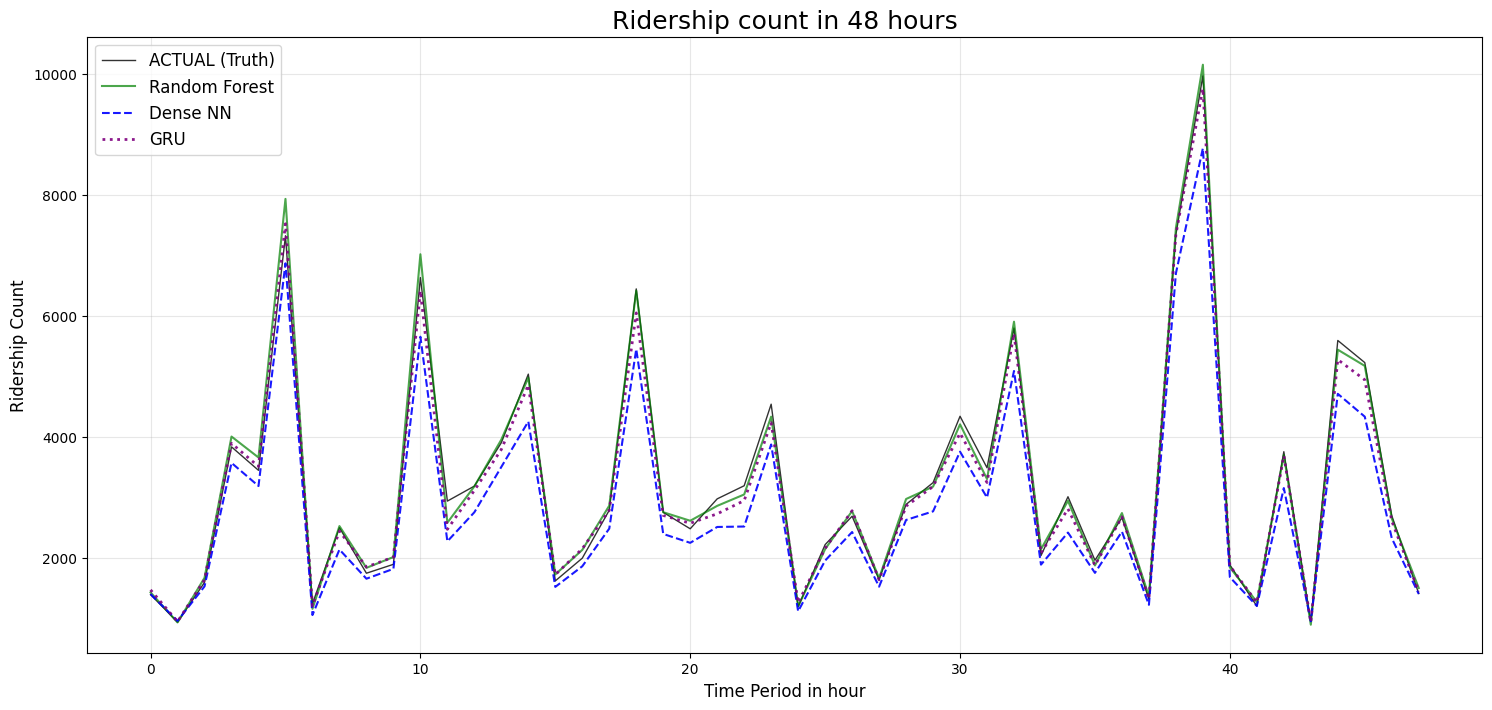

In [20]:
y_actual = y_true 
p_rf = y_pred_rf
p_nn = y_pred_nn
p_gru = y_pred_gru 

start = 2000
end = 2048

plt.figure(figsize=(18, 8))

plt.plot(y_actual[start:end], label='ACTUAL (Truth)', color='black', linewidth=1, alpha=0.8)

plt.plot(p_rf[start:end], label='Random Forest', color='green', linestyle='-', linewidth=1.5, alpha=0.7)
plt.plot(p_nn[start:end], label='Dense NN', color='blue', linestyle='--', linewidth=1.5, alpha=0.9)
plt.plot(p_gru[start:end], label='GRU', color='purple', linestyle=':', linewidth=2, alpha=0.9)

plt.title(f'Ridership count in {end - start} hours', fontsize=18)
plt.ylabel('Ridership Count', fontsize=12)
plt.xlabel('Time Period in hour', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()

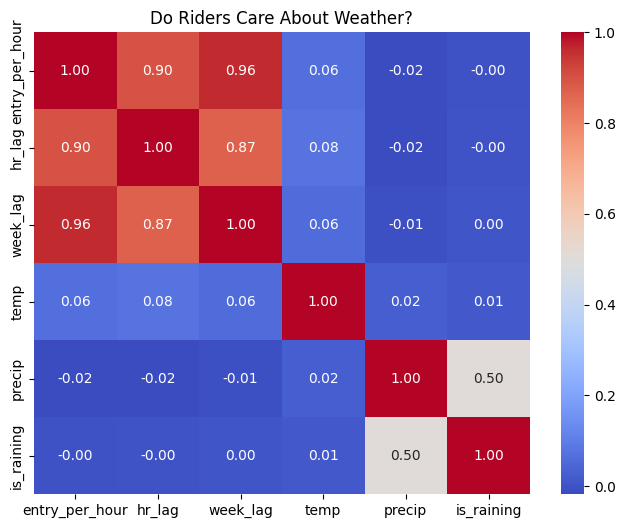

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns we care about
cols_to_check = ['entry_per_hour', 'hr_lag', 'week_lag', 'temp', 'precip', 'is_raining']
corr_matrix = df[cols_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Do Riders Care About Weather?")
plt.show()

In [ ]:
# Adding the weather data slghtly improved the performance of gru model, but other two got worse 
# random forest regressor performed slightly worse, but neural network model showed a geat improvement 
# Still, GRU performed better so GRU will be used for the website 
# the website will not have access to the live data, so use the data set's average data for the website's update
df_new = pd.read_csv('nyc_subway_ml_data.csv')
cheat_sheet = df_new.groupby(['station', 'borough', 'weekday', 'hour'])['entry_per_hour'].mean().reset_index()
cheat_sheet['entry_per_hour'] = cheat_sheet['entry_per_hour'].round(0).astype(int)
cheat_sheet.to_csv('station_averages.csv', index = False)

In [39]:
# save the scaler
joblib.dump(scale_X, 'scale_X.pkl')
joblib.dump(scale_y, 'scaler_y.pkl')

with open("col_X_names.pkl", "wb") as f:
    pickle.dump(col_X, f)
with open("oh_col_names.pkl", "wb") as f:
    pickle.dump(oh_cols, f)


In [40]:
# save the model
model_gru.save('gru_model.keras')